## Целью данных скриптов была демонстрация понимания основных алгоритмов компьютерного зрения и способность их практического применения для решения задач e-commerce.

## Задача: Разработка системы обработки фотографий с карточек товаров на маркетплейсах.

In [ ]:
# !pip install cvzone
# !pip install mediapipe
# !pip install rembg

In [ ]:
!pip uninstall Pillow echo Y
!pip install Pillow 

Found existing installation: pillow 10.4.0
Uninstalling pillow-10.4.0:
  Would remove:
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/_imaging.cpython-312-darwin.so
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/_imagingcms.cpython-312-darwin.so
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/_imagingft.cpython-312-darwin.so
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/_imagingmath.cpython-312-darwin.so
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/_imagingmorph.cpython-312-darwin.so
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/_imagingtk.cpython-312-darwin.so
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/_webp.cpython-312-darwin.so
    /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.

In [9]:
Y

NameError: name 'Y' is not defined

In [1]:
from glob import glob
import os
import sys
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import collections

import cv2
import cvzone
from cvzone.SelfiSegmentationModule import SelfiSegmentation
import mediapipe as mp
import torch
from rembg import remove, new_session

from google.colab import drive
drive.mount('/content/drive')

ImportError: cannot import name 'Image' from 'PIL' (unknown location)

### Так как нет сегментированной версии для изображений, я нашла небольшой датасет в открытых источниках. Так я смогу посчитать метрики качества сегментации для моделей.

### Данные, которые были предоставлены к заданию изначально, я использовала как тестовые, но не применяла к ним оценку метрик. Я просто зрительно оценила качество удаления фона.

In [4]:
# считаем данные с открытого источника

file_input_img = sorted(glob('/content/drive/MyDrive/data/my_data/input_img_new/*'))
file_segment_img = sorted(glob('/content/drive/MyDrive/data/my_data/segment_img_new/*'))

input_img = [] # список изображений до сегментации
segment_img = [] # маски сегментации

for i in range(len(file_input_img)):
    img_inp = Image.open(file_input_img[i])
    img_seg = Image.open(file_segment_img[i])

    img_inp = np.array(img_inp)
    img_seg = np.array(img_seg)

    input_img.append(img_inp)
    segment_img.append(img_seg)

In [4]:
len(input_img) == len(segment_img)

True

In [5]:
for ind, img in enumerate(input_img):
    result_1 = segment_img[ind]
    result_2 = input_img[ind]
    if result_1.shape != result_2.shape[:2]:
      print(result_1.shape, result_2.shape[:2], file_input_img[ind].split('/')[-1])


In [5]:
file_sirius_img = sorted(glob('/content/drive/MyDrive/data/sirius_data/sirius_data/*'))

sirius_img = []
for i in range(len(file_sirius_img)):
    img_sirius = Image.open(file_sirius_img[i])
    img_sirius = np.array(img_sirius)
    sirius_img.append(img_sirius)

### Задача 1: Удаление фона.
В качестве дополнительного задания было необходимо провести ричерч существующих алгоритмов для сегментации изображения с целью удаления фона. Начнем с данного рисерча и найдем наиболее оптимальный для нашего кейса подход.

Но для начала разберем метрики, которые использовались для оценки.

1. Основная метрика - IoU. Методом количественной оценки процентного перекрытия между целевой маской и нашим прогнозируемым результатом.

2. Доп. метрика - Pixel Accuracy. Идейно она является аналогом известной метрики Accuracy в классических задачах классификации. В нашем случае она покажет процент пикселей на изображении, которые были правильно определены. То есть правильно ли модель сделала, что удалила/оставила соответствующую часть фона на изображении.

In [6]:
def calc_metric_pixel_accuracy(y_pred, y_true):
  """Считает значение метрики Pixel Accuracy

  Args:
    y_pred (torch.tensor): Изображение, полученное моделью.
    y_true (torch.tensor): Истинный результат.

  Returns:
    result (float): Значение метрики Pixel Accuracy
  """
  y_pred_argmax = y_pred.argmax(dim=0)
  y_true_argmax = y_true

  correct_pixels = (y_pred_argmax == y_true_argmax).count_nonzero()
  uncorrect_pixels = (y_pred_argmax != y_true_argmax).count_nonzero()
  result = (correct_pixels / (correct_pixels + uncorrect_pixels)).item()

  return result

In [7]:
def calc_metric_iou(y_pred, y_true):
  """Считает значение метрики IoU

  Args:
    y_pred (torch.tensor): Изображение, полученное моделью
    y_true (torch.tensor): Истинный результат

  Returns:
    result (float): Значение метрики IoU
  """
  y_pred_hot = y_pred > 0.5

  intersection = torch.logical_and(y_pred_hot, y_true).count_nonzero()
  union = torch.logical_or(y_pred_hot, y_true).count_nonzero()
  result = (intersection / union).item()

  return result

In [8]:
def image_to_tensor(img):
  """Преобразует изображение в тензор

  Args:
    img (object): Изображение

  Returns:
    tensor (torch.tensor): Изображение в виде тензора
  """
  img_array = np.array(img)
  tensor = torch.from_numpy(img_array).float()
  try:
    tensor = tensor.permute(2, 0, 1)
  except:
    pass

  return tensor

#### Подход 1. Использование OpenCV с применением морфологии

Подробнее шаги изложены в комментариях к коду.

In [ ]:
def opencv_images(input_img):
  """Сегментирует одно изображение

  Args:
    input_img (object): Изображение

  Returns:
    result (object): Изображение после сегментации
  """
  lower = np.array([0, 0, 0]) # пороговые значение для черного
  upper = np.array([50, 50, 50])

  thresh = cv2.inRange(input_img, lower, upper) # применяем выделение черным для картинки
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25,25)) # применяем морфологию
  morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

  # получили контуры объекта
  contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # получили контуры объекта
  contours = contours[0] if len(contours) == 2 else contours[1]

  # нулевое изображение для всех контуров
  contours_mask = np.zeros_like(input_img, dtype=np.uint8)

  hh, ww = input_img.shape[:2]

  if len(contours) != 0:
    for i in range(len(contours)):
      if len(contours[i]) >= 5:
        cv2.drawContours(thresh,contours,-1,(150,10,255),3)
        ((centx,centy), (width,height), angle)=cv2.fitEllipse(contours[i])
        # нарисовали круг, используя средние радиусы эллипса и центр, заполненный белым цветом на черном фоне
        try:
          width = int(width)
          height = int(height)
          cx = int(centx)
          cy = int(centy)
          radius = (width+height)/4
          cv2.circle(contours_mask[i], (cx,cy), int(radius), 0, -1)
        except:
          continue

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6))
        contours_mask[i] = cv2.erode(contours_mask[i], kernel)

  # сформировали и применили итоговую маску
  final_contours_mask = np.max(contours_mask, axis=-1)

  input_img = input_img.astype(np.uint8)
  final_contours_mask = final_contours_mask.astype(np.uint8)

  result = cv2.bitwise_and(input_img, input_img, mask=final_contours_mask)

  return result


In [280]:
def opencv_method_model(input_img, segment_img, dir_data):
  """Прогоняет массив иображений через алгоритм и считает значения метрик качества сегментации

  Args:
    input_img (list): Список входных изображений
    segment_img (list): Список сегментированных изображений (истинных)
    dir_data (str): Путь до папки с сегментированными алгоритмом изображениями

  Returns:
    metric_iou (float): Значение метрики IoU
    metric_pix_acc (float): Значение метрики Pixel Accuracy
    history_metrics_open_cv (dict): Cловарь с детализацией расчитанных метрик
  """
  history_metrics_open_cv = {'iou': [], 'pixel_accuracy': []}

  for ind, _ in enumerate(input_img):
    true_result = segment_img[ind]

    try:
      pred_result = opencv_images(input_img[ind])
    except:
      print(file_input_img[ind].split('/')[-1])
      continue

    pred_img = Image.fromarray(pred_result.astype(np.uint8))
    pred_img.save(f"{dir_data}{file_input_img[ind].split('/')[-1]}", 'JPEG')

    pred_result_tensor = image_to_tensor(pred_result)
    true_result_tensor = image_to_tensor(true_result)

    iou = calc_metric_iou(pred_result_tensor, true_result_tensor)
    pix_acc = calc_metric_pixel_accuracy(pred_result_tensor, true_result_tensor)

    history_metrics_open_cv['iou'].append(iou)
    history_metrics_open_cv['pixel_accuracy'].append(pix_acc)

  metric_iou = np.mean(history_metrics_open_cv['iou'])
  metric_pix_acc = np.mean(history_metrics_open_cv['pixel_accuracy'])

  return metric_iou, metric_pix_acc, history_metrics_open_cv


In [ ]:
# Прогоняем через алгоритм массив изображений
metric_iou, metric_pix_acc, \
history_metrics_open_cv = opencv_method_model(input_img,
                                              segment_img,
                                              '/content/drive/MyDrive/data/my_data/predict_img_new/')


In [285]:
metric_iou, metric_pix_acc

(0.31732949974298597, 0.5708320505939581)

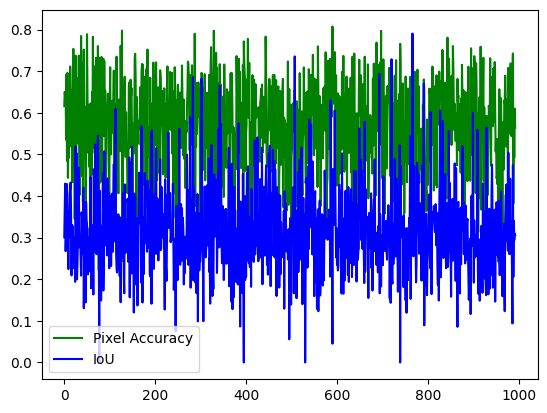

In [286]:
plt.plot(
    history_metrics_open_cv['pixel_accuracy'], 'green',
    history_metrics_open_cv['iou'], 'blue',
)
plt.legend(('Pixel Accuracy', 'IoU'))
plt.show()

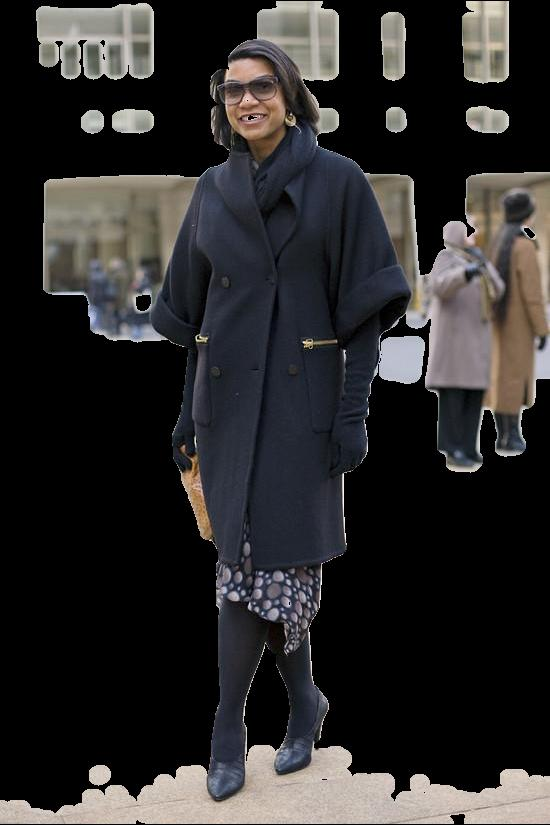

In [290]:
Image.open('/content/drive/MyDrive/data/my_data/predict_img_new/img_0090.png')

#### Опробуем на данных, которые были предоставлены изначально

In [ ]:
for i, _ in enumerate(sirius_img):
  pred_tensor = opencv_images(sirius_img[i])
  pred_img = Image.fromarray(pred_tensor.astype(np.uint8))
  pred_img.save(f"/content/drive/MyDrive/data/my_data/pred_test_new/{file_sirius_img[i].split('/')[-1]}", 'JPEG')


#### Если честно, я долго пыталась сделать так, чтобы алгоритм начал корректно сегментрировать объекты, но не вышло. Он плохо понимает, где границы объекта.

#### Подход 2. Использование SelfiSegmentation CVZone
Подробнее шаги изложены в комментариях к коду.

Данный алгоритм предполагает обработку не очень сложных случаев, когда детектировать объект можно достаточно явно. Судя по приложенным к заданию датасету, это нам подходит.
Простота алгоритма дает нам еще и высокую производительность.


In [11]:
def selfiseg_method_model(input_img, segment_img, dir_data, cutThreshold):
  """Прогоняет массив иображений через метод SelfiSegmentation.removeBG

  Args:
    input_img (list): Список входных изображений
    segment_img (list): Список сегментированных изображений (истинных)
    dir_data (str): Путь до папки с сегментированными алгоритмом изображениями
    cutThreshold (float): Порог сегментации

  Returns:
    metric_iou (float): Значение метрики IoU
    metric_pix_acc (float): Значение метрики Pixel Accuracy
    history_metrics_selfiseg (dict): Cловарь с детализацией расчитанных метрик
    segmentor (object): Обученная модель
  """
  history_metrics_selfiseg = {'iou': [], 'pixel_accuracy': []}
  segmentor = SelfiSegmentation()

  for ind, _ in enumerate(input_img):
    true_result = segment_img[ind]

    pred_result = segmentor.removeBG(input_img[ind], (0,0,0), cutThreshold=cutThreshold)
    pred_img = Image.fromarray(pred_result.astype(np.uint8))
    pred_img.save(f"{dir_data}{file_input_img[i].split('/')[-1]}", 'JPEG')

    pred_result_tensor = image_to_tensor(pred_result)
    true_result_tensor = image_to_tensor(true_result)

    iou = calc_metric_iou(pred_result_tensor, true_result_tensor)
    pix_acc = calc_metric_pixel_accuracy(pred_result_tensor, true_result_tensor)

    history_metrics_selfiseg['iou'].append(iou)
    history_metrics_selfiseg['pixel_accuracy'].append(pix_acc)

  metric_iou = np.mean(history_metrics_selfiseg['iou'])
  metric_pix_acc = np.mean(history_metrics_selfiseg['pixel_accuracy'])

  return metric_iou, metric_pix_acc, history_metrics_selfiseg, segmentor

#### Прогоняем через метод масиив изображений. При этом также подбираем оптимальный парамент cutThreshold, на котором качество сегментации будут наилучшим

In [ ]:
dir_inp_name = '/content/drive/MyDrive/data/my_data/predict_SelfiSegmentation/'
segm_dict = {}
metr_iou = {}
metr_pix_acc = {}

for i in range(1,10):
  trsh = i/10
  m_iou, m_pix_acc, m_dict, segm = selfiseg_method_model(input_img,
                                                         segment_img,
                                                         dir_inp_name,
                                                         trsh)
  metr_iou[trsh] = m_iou
  metr_pix_acc[trsh] = m_pix_acc

  segm_dict[trsh] = segm

metric_selfiseg = {'iou': collections.OrderedDict(sorted(metr_iou.items())),
                   'pixel_accuracy': collections.OrderedDict(sorted(metr_pix_acc.items()))}

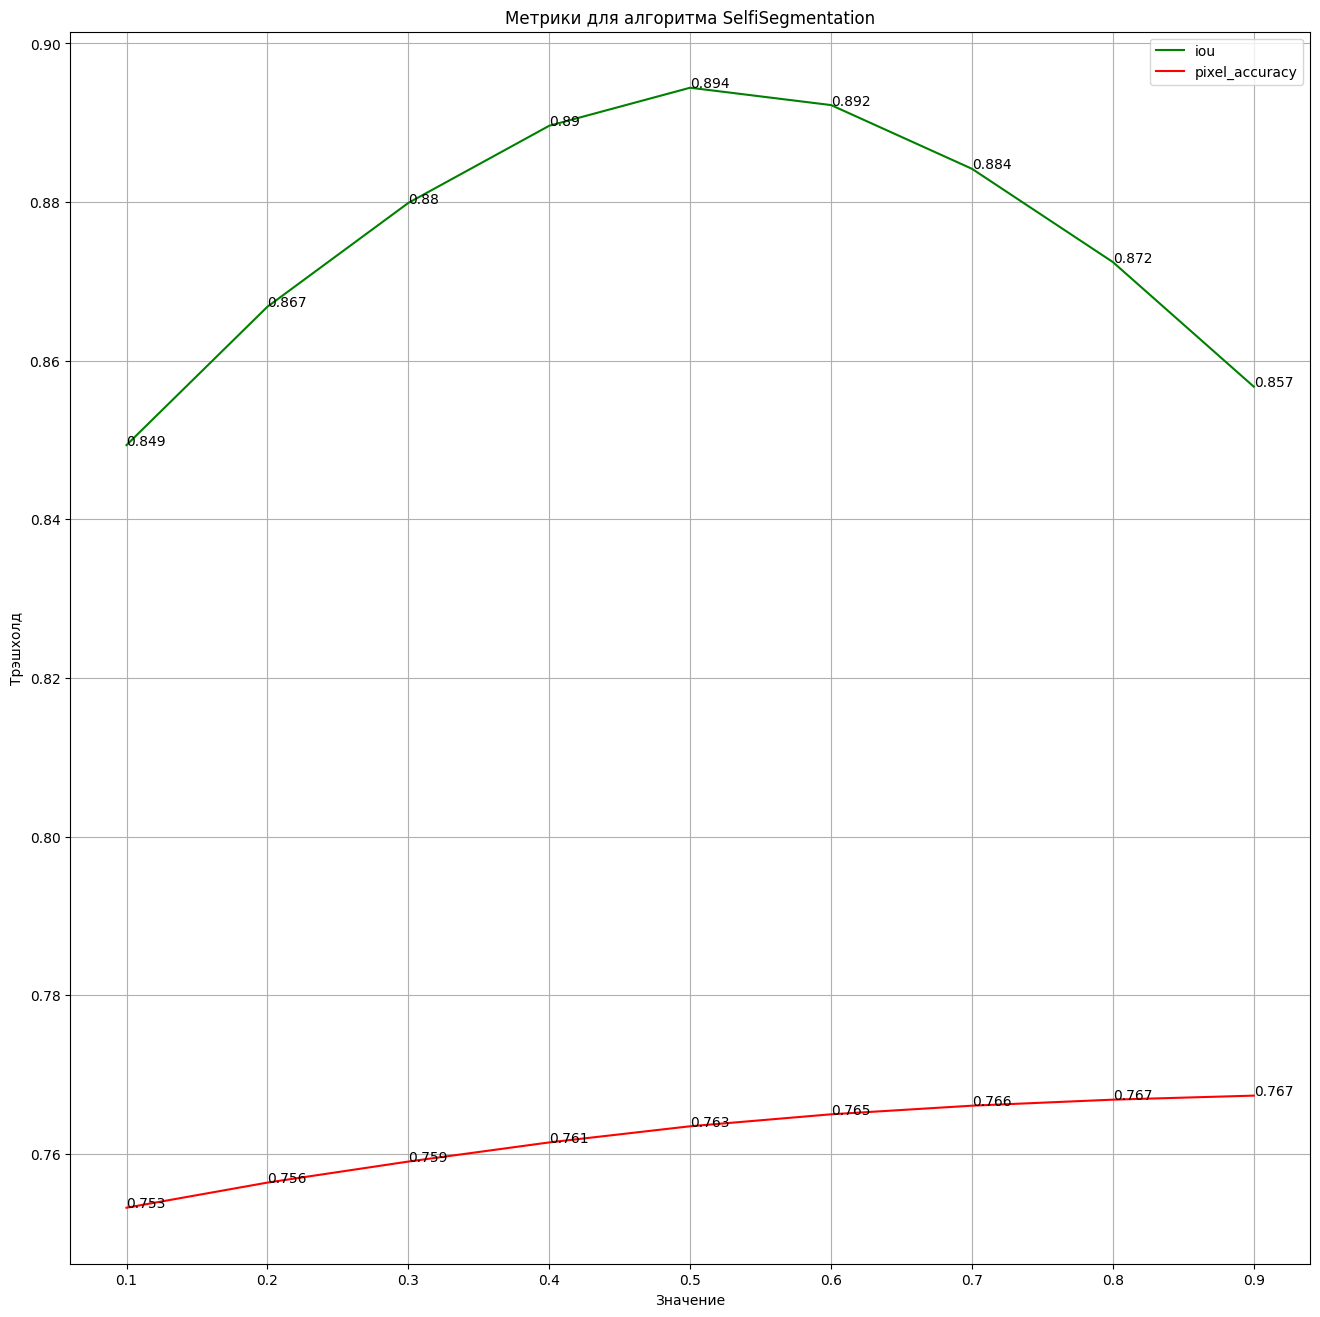

In [38]:
plt.figure(figsize=(16, 16))

plt.plot(metric_selfiseg['iou'].keys(),
         metric_selfiseg['iou'].values(),
         label='iou',
         color = 'green')
for i, txt in enumerate(metric_selfiseg['iou'].values()):
  plt.annotate(f'{np.round(txt, 3)}',
               (list(metric_selfiseg['iou'].keys())[i],
                list(metric_selfiseg['iou'].values())[i]))

plt.plot(metric_selfiseg['pixel_accuracy'].keys(),
         metric_selfiseg['pixel_accuracy'].values(),
         label='pixel_accuracy',
         color = 'red')
for i, txt in enumerate(metric_selfiseg['pixel_accuracy'].values()):
  plt.annotate(f'{np.round(txt, 3)}',
               (list(metric_selfiseg['pixel_accuracy'].keys())[i],
                list(metric_selfiseg['pixel_accuracy'].values())[i]))

plt.title('Метрики для алгоритма SelfiSegmentation')
plt.ylabel('Трэшхолд')
plt.xlabel('Значение')
plt.legend()
plt.grid(True)
plt.savefig('SelfiSegmentation_metrics.png', dpi = 300, bbox_inches = 'tight')
plt.show()

#### Лучшее значение метрики IoU достигает своего лучшего значения 0.894 при пороге сегментации 0.5. Используем это значение при применении для данных из задания

In [40]:
best_trsh = 0.5
best_segm = segm_dict[best_trsh]

for i, _ in enumerate(sirius_img):
    pred_result = best_segm.removeBG(sirius_img[i], (0,0,0), cutThreshold=best_trsh)
    pred_img = Image.fromarray(pred_result.astype(np.uint8))
    pred_img.save(f"/content/drive/MyDrive/data/my_data/sirius_selfiseg/{file_sirius_img[i].split('/')[-1]}", 'JPEG')

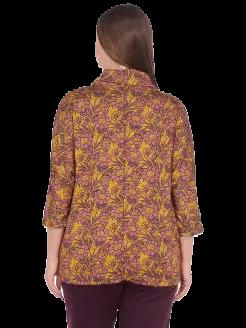

In [295]:
Image.open('/content/drive/MyDrive/data/my_data/sirius_selfiseg/390.jpg')

#### Проанализировав результаты сегментации данным методом, увидели более высокий уровень его применимости, чем подход 1. Немного реже обрезаются важные части товара.

По результирующим картинкам выявила следующие проблемные кейсы:

1. Если и товар, и фон достаточно светлые/белые, очень плохо его распознает.
2. Когда товар - книга, то он распознает именно рисунок на книге.

Однако из плюсов данного метода можно отметить:
1. Если товар надет на человека, то сегментирует достаточно хорошо. Не обрезаются важные части.


### Подход 3. Использование rembg

Алгоритм более тяжел для вычислений, чем Подход 2, но обладает более высокой точностью сегментации, особенно для сложных изображений. Также есть возможность использование различных предобученных моделей. Я рассмотрела архитектуры: U2-Net, RCNN, DeepFillv2.

Подбираем архитектуру модели для получения наилучших значений метрик оценки качества сегментации.


In [254]:
def rembg_method_model(input_img, segment_img, params, dir_data = None):
  """Прогоняет массив иображений через метод rembg.remove

  Args:
    input_img (list): Список входных изображений
    segment_img (list): Список сегментированных изображений (истинных)
    params (dict): Параметры модели
    dir_data (str): Путь до папки с сегментированными алгоритмом изображениями

  Returns:
    metric_iou (float): Значение метрики IoU
    metric_pix_acc (float): Значение метрики Pixel Accuracy
    history_metrics_rembg (dict): Cловарь с детализацией расчитанных метрик
  """
  history_metrics_rembg = {'iou': [], 'pixel_accuracy': []}

  for ind, _ in enumerate(input_img):
    true_result = segment_img[ind]

    params['data'] = input_img[ind]
    pred_result = remove(**params)

    pred_img = Image.fromarray(pred_result.astype(np.uint8))

    if dir_data:
      pred_img.save(f"{dir_data}{file_input_img[ind].split('/')[-1]}", 'JPEG')

    pred_result_tensor = image_to_tensor(pred_result)
    true_result_tensor = image_to_tensor(true_result)

    iou = calc_metric_iou(pred_result_tensor, true_result_tensor)
    pix_acc = calc_metric_pixel_accuracy(pred_result_tensor, true_result_tensor)

    history_metrics_rembg['iou'].append(iou)
    history_metrics_rembg['pixel_accuracy'].append(pix_acc)

  metric_iou = np.mean(history_metrics_rembg['iou'])
  metric_pix_acc = np.mean(history_metrics_rembg['pixel_accuracy'])

  return metric_iou, metric_pix_acc, history_metrics_rembg

In [ ]:
# архитектуры предобученных моделей
model_name = ["u2net", "deepfillv2", "mask_rcnn"]

metr_iou = {}
metr_pix_acc = {}
metr_session = {}
params = {'only_mask': True}

for mn in model_name:
  params['session'] = new_session(mn)
  m_iou, m_pix_acc, m_dict = rembg_method_model(input_img,
                                                segment_img,
                                                params)

  # сохраняем метрики
  key_metric = f"{mn}"
  metr_iou[key_metric] = m_iou
  metr_pix_acc[key_metric] = m_pix_acc
  metr_session[key_metric] = params['session']

In [69]:
best_key_iou = next((k for k, v in metr_iou.items() if v == max(metr_iou.values())), None)
best_key_pix = next((k for k, v in metr_pix_acc.items() if v == max(metr_pix_acc.values())), None)

print(best_key_iou, ':', round(max(metr_iou.values()), 3))
print(best_key_pix, ':', round(max(metr_pix_acc.values()), 3))

u2net : 0.898
u2net : 0.519


In [21]:
best_rembg_session = metr_session['u2net']
params = {'only_mask': False, 'session': best_rembg_session}

for i, _ in enumerate(sirius_img):
  params['data'] = sirius_img[i]
  pred_result = remove(**params)
  pred_img = Image.fromarray(pred_result.astype(np.uint8))

  pred_img.save(f"/content/drive/MyDrive/data/my_data/sirius_rembg/{file_sirius_img[i].split('/')[-1]}", 'PNG')

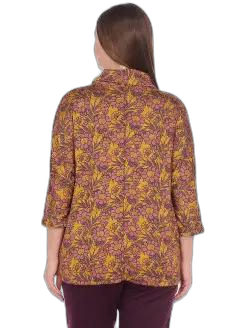

In [296]:
Image.open('/content/drive/MyDrive/data/my_data/sirius_rembg/390.jpg')

#### Метод rembg.remove() с архитектурой u2net показал значение метрик IoU и Pixel Accuracy 0.898 и 0.519 соответственно.

#### Применили его на данных,и предоставленных к заданию. Неплохо сегментирует. Но выделила следующие проблемные кейсы: !!!!

#### Так мы определили оптимальный подход из рассмотренных. Это послений подход - rembg.remove(). Его будет использовать как итоговое решение. И с помошью него же будем производить замену фона.

### Задача 2: Замена стертого фона на другой.

Я думаю оптимально будет предоставить тому, кто пользуется скриптом, выбор, какой фон хочется установить: однотонный фон, градиент или готовое изображение для фона. Реализуем функцию, которая будет принимать желаемый новый фон и, соответственно, производить замену. Я загрузила в репо несколько заготовок, но пользователь может загрузить свои и воспользоваться ими.
Если пользователь ничего не загрузит, то фон сотрется и заменится на черный.

In [247]:
def draw_new_back(image, background_color=None, background_img = []):
  image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR) if image.shape[2] == 4 else image

  mask = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

  image_mask = cv2.bitwise_and(np.array(image), np.array(image), mask=mask)
  inverse_mask = cv2.bitwise_not(mask)

  if len(background_img) > 0:
    backgr = cv2.resize(background_img,
                        tuple(reversed(np.array(image).shape[:2])))
  elif background_color:
    if isinstance(background_color, str):
      background_color = background_color.lstrip('#')
      background_color = tuple(int(background_color[i:i+2], 16) for i in (0, 2, 4))
    backgr = background_color
  else:
    return image

  new_back = np.full(np.array(image).shape, backgr, dtype=np.uint8)

  background = cv2.bitwise_and(new_back, new_back, mask=inverse_mask)
  return cv2.add(image_mask, background)

In [ ]:
for i, _ in enumerate(sirius_img):
  pred_result = remove(sirius_img[i])
  background_img = cv2.imread('/content/drive/MyDrive/data/my_data/img_backgrounds/белое_полотно_фотостудии.png')
  background_img = np.array(background_img)
  background_color = (210, 180, 170)

  pred_img = draw_new_back(pred_result,
                                background_color = background_color,
                                background_img = [])
  pred_img_res = Image.fromarray(pred_img.astype(np.uint8))
  pred_img_res.save(
  f"/content/drive/MyDrive/data/my_data/sirius_rembg_with_color/{file_sirius_img[i].split('/')[-1]}", 'PNG')

  pred_img = draw_new_back(pred_result,
                                background_color = None,
                                background_img = background_img)
  pred_img_res = Image.fromarray(pred_img.astype(np.uint8))
  pred_img_res.save(
  f"/content/drive/MyDrive/data/my_data/sirius_rembg_with_img/{file_sirius_img[i].split('/')[-1]}", 'PNG')

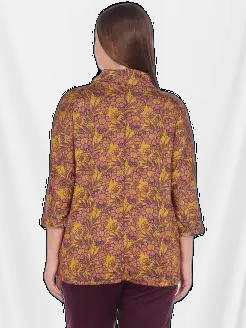

In [297]:
Image.open('/content/drive/MyDrive/data/my_data/sirius_rembg_with_img/390.jpg')

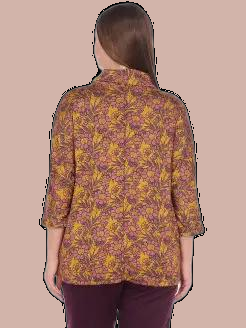

In [298]:
Image.open('/content/drive/MyDrive/data/my_data/sirius_rembg_with_color/390.jpg')